In [1]:
import xarray as xr
import pyorc
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Scanning video: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


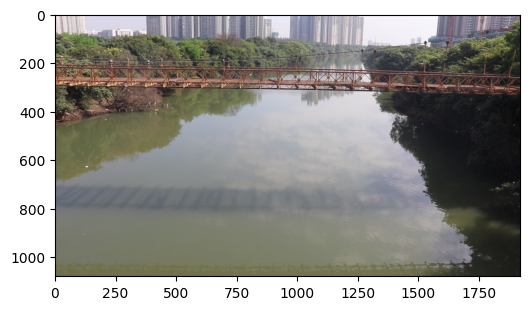

In [2]:
#%matplotlib notebook
video_file = r"../Videos/bridge_main_1.MP4"
video = pyorc.Video(video_file, start_frame=0, end_frame=1)  # we only need one frame
frame = video.get_frame(0, method="rgb")

# plot frame on a notebook-style window
f = plt.figure(figsize=(6, 6))
plt.imshow(frame)
#plt.savefig("BR_final.png")

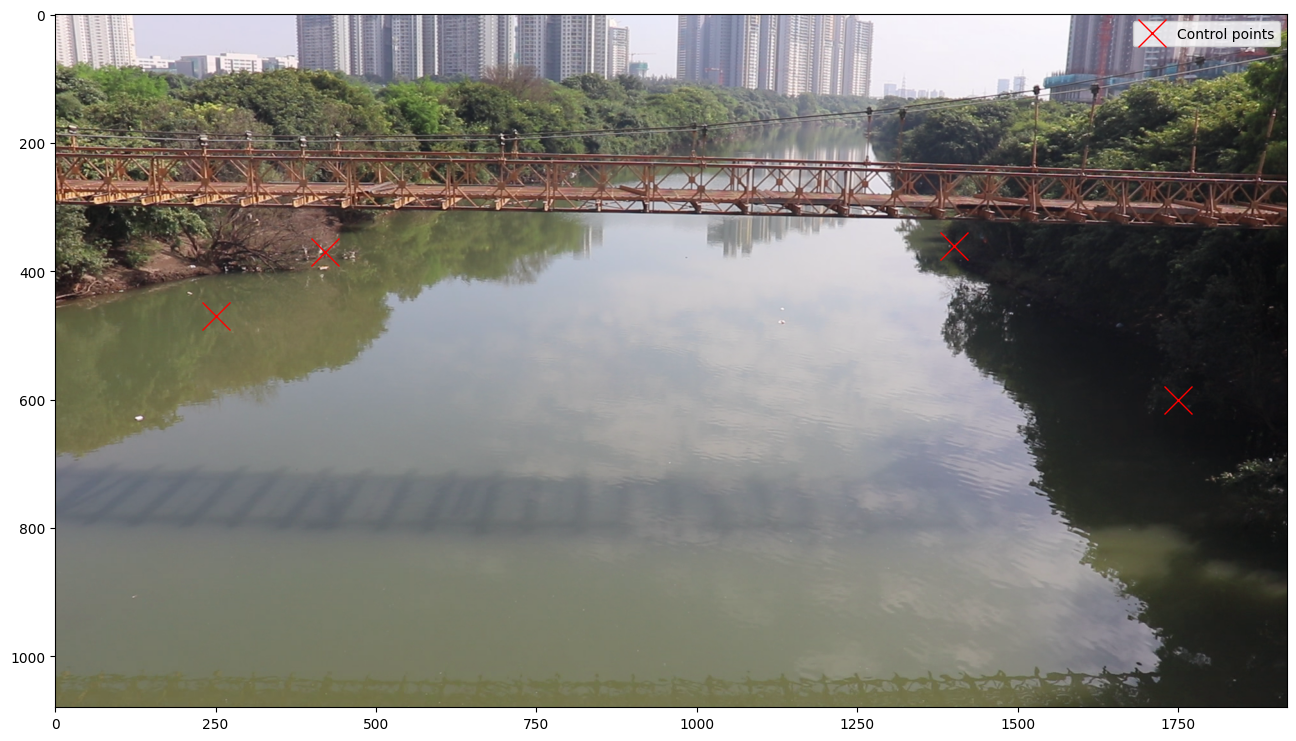

In [3]:
%matplotlib inline
gcps = dict(
    src=[
    [1750, 600],   # bottom right
    [1400 , 360],   #  top right 
    [420, 370],    # top left 
    [250 , 470]     # bottom left 
]
)

f = plt.figure(figsize=(16, 9))
plt.imshow(frame)
plt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")
plt.legend()

# current cords - 18.56899 , 73.733471

In [4]:
# first add our UTM 35S coordinates. This MUST be in precisely the same order as the src coordinates.

gcps["dst"] = [
    [366400.720, 2053619.745],  # bottom right (matches src[0])
    [366418.640, 2053631.682],  # top right (matches src[1]) 
    [366362.501, 2053663.064],  # top left (matches src[2])
    [366353.367, 2053654.939]   # bottom left (matches src[3])
]

# # if we would use this video as survey in video, the lines below are also needed, 
# # and proper values need to be filled in. They are now commented out.
# gcps["h_ref"] = <your locally measured water level during survey in>
gcps["z_0"] = 0

# set the height and width
height, width = frame.shape[0:2]

# now we use everything to make a camera configuration
# Using EPSG:32643 (UTM Zone 43N) which is correct for your location (18.57°N, 73.73°E)
cam_config = pyorc.CameraConfig(height=height, width=width, gcps=gcps, crs=32643, lens_position=[366343.108, 2053606.870, 30])

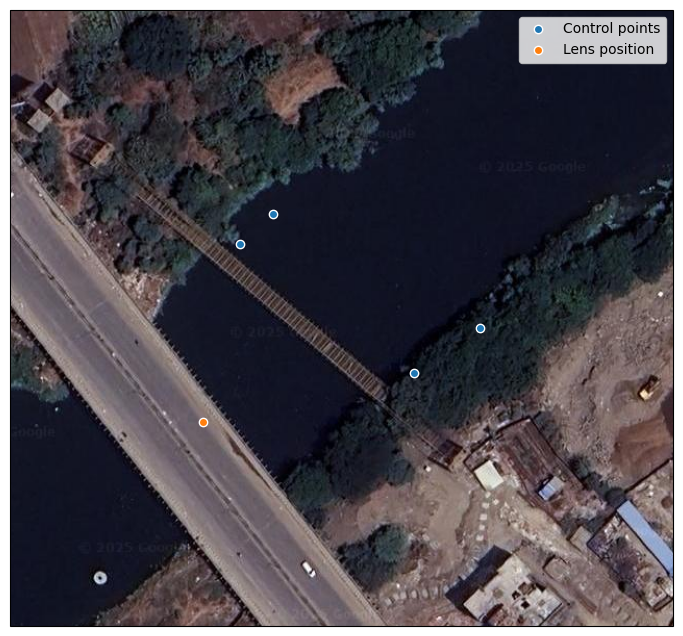

In [5]:
ax = cam_config.plot(tiles="GoogleTiles", tiles_kwargs={"style": "satellite"})

In [6]:
corners = [
    [250 ,600],   # bottom left
    [500 , 400],   #  top left 
    [1400 , 400],    # top right
    [1500 , 600]     # bottom right
]
#cam_config.set_bbox_from_corners(corners)

from shapely.geometry import Polygon

bbox_coords = [
    (366351.969, 2053651.297),
    (366365.040, 2053663.932),
    (366409.232, 2053629.534),
    (366391.942, 2053617.261),
    (366351.969, 2053651.297)
]

bbox_polygon = Polygon(bbox_coords)

cam_config.bbox = bbox_polygon 


'''cam_config.resolution = 38
cam_config.window_size = 25000
print(cam_config.get_bbox() )

f = plt.figure(figsize=(10, 6))
plt.imshow(frame)
plt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")


plt.plot(*zip(*corners), "co", label="Corners of AOI")
plt.legend()'''


# https://coordinates-converter.com/en/decimal/18.568943,73.733518?karte=OpenStreetMap&zoom=19

# https://earth.google.com/web/search/maan+road+connector+bridge/@18.56939012,73.73385109,571.87842292a,190.95937197d,35y,-0h,0t,0r/data=CokBGlsSVQolMHgzYmMyYmJlOWFiOGJlN2JiOjB4ZWUxMTc4ZWViYjkxMDU1YRlKo7iZwJMyQCGBaJw8m21SQCoabWFhbiByb2FkIGNvbm5lY3RvciBicmlkZ2UYASABIiYKJAmhzozUeoM1QBGgzozUeoM1wBms65EmEedJQCGs65EmEedJwEICCAE6AwoBMEICCABKDQj___________8BEAA


'cam_config.resolution = 38\ncam_config.window_size = 25000\nprint(cam_config.get_bbox() )\n\nf = plt.figure(figsize=(10, 6))\nplt.imshow(frame)\nplt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")\n\n\nplt.plot(*zip(*corners), "co", label="Corners of AOI")\nplt.legend()'

In [7]:
import numpy as np
import cv2

# Image GCPs (pixel)
img_pts = np.array(gcps["src"], dtype=np.float32)

# World GCPs (X, Y → X, Y, Z=0)
world_pts = np.array([
    [x, y, 0] for x, y in gcps["dst"]
], dtype=np.float32)

camera_matrix = np.array(cam_config.camera_matrix, dtype=np.float32)
dist_coeffs   = np.array(cam_config.dist_coeffs, dtype=np.float32)

ok, rvec, tvec = cv2.solvePnP(
    world_pts,
    img_pts,
    camera_matrix,
    dist_coeffs,
    flags=cv2.SOLVEPNP_ITERATIVE
)

print("rvec =", rvec)
print("tvec =", tvec)


rvec = [[ 1.86022791]
 [-0.69781633]
 [ 0.42677811]]
tvec = [[ 1038528.06689258]
 [  661729.09555832]
 [-1683768.52006061]]


In [8]:
bbox_3d = np.array([
    [366351.969, 2053651.297, 0],
    [366365.040, 2053663.932, 0],
    [366409.232, 2053629.534, 0],
    [366391.942, 2053617.261, 0],
    [366351.969, 2053651.297, 0],
], dtype=np.float32)

img_bbox, _ = cv2.projectPoints(
    bbox_3d, rvec, tvec, camera_matrix, dist_coeffs
)

img_bbox = img_bbox.reshape(-1, 2)


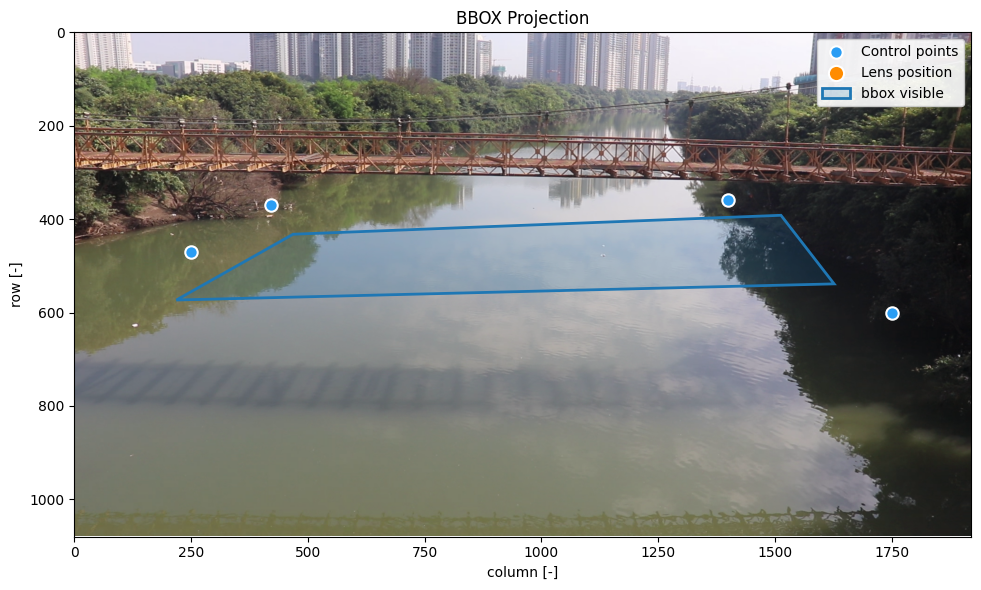

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(frame)

# -------------------------
# Plot GCPs
# -------------------------
ax.scatter(
    img_pts[:, 0], img_pts[:, 1],
    s=80, color="#2a9df4", edgecolor="white", linewidth=1.5,
    label="Control points"
)

# -------------------------
# Plot lens position (optional)
# -------------------------
if "lens_position" in cam_config.__dict__:
    lp = np.array(cam_config.lens_position[:2], dtype=np.float32)
    lp3d = np.hstack([lp, 0]).reshape(1, 3)
    lp_img, _ = cv2.projectPoints(lp3d, rvec, tvec, camera_matrix, dist_coeffs)
    lp_img = lp_img.reshape(2)

    ax.scatter(
        lp_img[0], lp_img[1],
        s=120, color="#ff8c00", edgecolor="white", linewidth=1.5,
        label="Lens position"
    )

# -------------------------
# Plot BBOX as semi-transparent polygon
# -------------------------
poly = patches.Polygon(
    img_bbox,
    closed=True,
    facecolor="#1f77b430",   # blue with 30% alpha
    edgecolor="#1f77b4",
    linewidth=2,
    label="bbox visible"
)
ax.add_patch(poly)

# -------------------------
# Formatting
# -------------------------
ax.set_title("BBOX Projection")
ax.set_xlabel("column [-]")
ax.set_ylabel("row [-]")

ax.set_xlim(0, frame.shape[1])
ax.set_ylim(frame.shape[0], 0)

ax.legend(loc="upper right", framealpha=0.9)

plt.tight_layout()
plt.show()


In [10]:
print(cam_config)
cam_config.to_file("Outputs/BR.json")

{
    "height": 1080,
    "width": 1920,
    "crs": "PROJCRS[\"WGS 84 / UTM zone 43N\",BASEGEOGCRS[\"WGS 84\",ENSEMBLE[\"World Geodetic System 1984 ensemble\",MEMBER[\"World Geodetic System 1984 (Transit)\"],MEMBER[\"World Geodetic System 1984 (G730)\"],MEMBER[\"World Geodetic System 1984 (G873)\"],MEMBER[\"World Geodetic System 1984 (G1150)\"],MEMBER[\"World Geodetic System 1984 (G1674)\"],MEMBER[\"World Geodetic System 1984 (G1762)\"],MEMBER[\"World Geodetic System 1984 (G2139)\"],MEMBER[\"World Geodetic System 1984 (G2296)\"],ELLIPSOID[\"WGS 84\",6378137,298.257223563,LENGTHUNIT[\"metre\",1]],ENSEMBLEACCURACY[2.0]],PRIMEM[\"Greenwich\",0,ANGLEUNIT[\"degree\",0.0174532925199433]],ID[\"EPSG\",4326]],CONVERSION[\"UTM zone 43N\",METHOD[\"Transverse Mercator\",ID[\"EPSG\",9807]],PARAMETER[\"Latitude of natural origin\",0,ANGLEUNIT[\"degree\",0.0174532925199433],ID[\"EPSG\",8801]],PARAMETER[\"Longitude of natural origin\",75,ANGLEUNIT[\"degree\",0.0174532925199433],ID[\"EPSG\",8802]],PARA